# Описание проекта
Область - многоклассовая классификация.
</br>В данном проекте создается модель компьютерного зрения, по фото дерева определяющей принадлежность к одному из 41 наиболее распространенному виду в г.Минске и окрестностях.
</br>Для этой задачи возьмем фотографии из датасета айнат21.
</br>Для построения модели будем использовать фреймворк PyTorch, как наиболее популярный для глубокого обучения нейросетей.
В модели будет предусмотрено отнесение дерева к классу 'OTHER', если оно не определено как наиболее часто встречающееся. А также защита от 'дурака', позволяющая выявлять объекты, не являющиеся деревьями. Во избежание поломки модели.
</br> Второй частью проекта будет применение его в реальности, через заливку на сервер и доступ по API.

Импорт рабочих модулей:

In [56]:
import os
import random
import json
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torchvision as tv
import timm
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm  
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from time import sleep
from IPython.display import display

In [2]:
print(torch.__version__)

2.1.1+cu121


In [3]:
torch.cuda.is_available()

True

In [5]:
# фиксируем random seed
SEED = 88888

Проверка доступности CUDA 

In [6]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

Загрузим данные:

In [7]:
img_path = 'data/kb'
plant_list = os.listdir(img_path) 
len(plant_list)
display(plant_list[:15])

['Fraxinus_pennsylvanica',
 'Populus_berolinensis',
 'Salix_babylonica',
 'Populus_alba',
 'Malus_toringo',
 'Quercus_robur',
 'Salix_alba',
 'Aesculus_hippocastanum',
 'Larix_sibirica',
 'Picea_abies',
 'Carpinus_betulus',
 'Caragana_arborescens',
 'Acer_campestre',
 'Acer_platanoides',
 'Acer_saccharinum']

Объединяем путь к картинке для каждого вида из 'plant_list' с самой картинкой и создаем датафрейм:

In [8]:
# список для пути
paths = []

# список для хранения классов растений
labels_list = []

for plant in plant_list:
    plant_path = os.path.join(img_path, plant)
    items = os.listdir(plant_path)
    for item in items:
        paths.append(os.path.join(plant_path, item))
        labels_list.append(plant)
        
df  = pd.DataFrame()
df['tree_types'] = labels_list
df['file_paths'] = paths
df.shape, df.head(3)

((10246, 2),
                tree_types                                         file_paths
 0  Fraxinus_pennsylvanica  data/kb/Fraxinus_pennsylvanica/f3ce0c2d-8b17-4...
 1  Fraxinus_pennsylvanica  data/kb/Fraxinus_pennsylvanica/a1847203-84a5-4...
 2  Fraxinus_pennsylvanica  data/kb/Fraxinus_pennsylvanica/abd76c22-1aa7-4...)

Проверим, что лежит в датафрейме `df`:

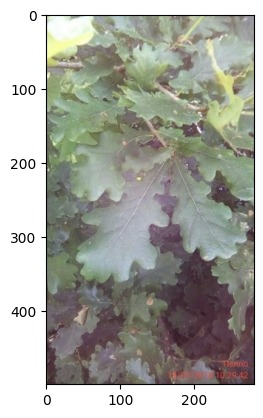

In [9]:
rnd_df = df.iloc[random.randint(0, df.shape[0] - 1)]
img_df = rnd_df ['file_paths']
img_df = Image.open(img_df )
plt.imshow(img_df)

Создаем датафрейм 'other' для остальных растений, которые не входит в 41 определяемый моделью класс:

In [11]:
display(os.listdir("data/imagenet_tiny")[:15])

['val_3664.JPEG',
 'val_5900.JPEG',
 'val_5898.JPEG',
 'val_1097.JPEG',
 'val_7780.JPEG',
 'val_5984.JPEG',
 'val_6607.JPEG',
 'val_6024.JPEG',
 'val_2280.JPEG',
 'val_266.JPEG',
 'val_3106.JPEG',
 'val_2527.JPEG',
 'val_9750.JPEG',
 'val_9117.JPEG',
 'val_3343.JPEG']

In [12]:
display(os.listdir("data/val")[:15])

['02189_Animalia_Arthropoda_Insecta_Lepidoptera_Sphingidae_Eumorpha_achemon',
 '06194_Plantae_Tracheophyta_Liliopsida_Liliales_Melanthiaceae_Trillium_catesbaei',
 '03689_Animalia_Chordata_Aves_Passeriformes_Aegithalidae_Psaltriparus_minimus',
 '08357_Plantae_Tracheophyta_Magnoliopsida_Gentianales_Rubiaceae_Oldenlandia_corymbosa',
 '04786_Animalia_Chordata_Mammalia_Primates_Cercopithecidae_Macaca_mulatta',
 '05241_Animalia_Mollusca_Bivalvia_Pectinida_Pectinidae_Crassadoma_gigantea',
 '06021_Plantae_Tracheophyta_Liliopsida_Asparagales_Orchidaceae_Dactylorhiza_majalis',
 '08502_Plantae_Tracheophyta_Magnoliopsida_Lamiales_Lamiaceae_Scutellaria_integrifolia',
 '04828_Animalia_Chordata_Mammalia_Rodentia_Sciuridae_Glaucomys_volans',
 '04543_Animalia_Chordata_Aves_Strigiformes_Strigidae_Athene_brama',
 '07604_Plantae_Tracheophyta_Magnoliopsida_Cornales_Cornaceae_Cornus_sericea',
 '09997_Plantae_Tracheophyta_Polypodiopsida_Salviniales_Salviniaceae_Azolla_filiculoides',
 '02359_Animalia_Arthropo

In [13]:
paths = []
labels_list = []  # целевая метка
for plant in os.listdir('data/val'):
    if plant not in plant_list and 'Plantae' in plant: # доп фильтр, что подтягиваем только растения 
        plant_path = os.path.join('data/val', plant)
        items = os.listdir(plant_path)
        for item in items:
            paths.append(os.path.join(plant_path, item))
            labels_list.append('Other')
        
df_other = pd.DataFrame()        
df_other['file_paths'] = paths
df_other['tree_types'] = labels_list
df_other.shape, df_other.head(3)


((42710, 2),
                                           file_paths tree_types
 0  data/val/06194_Plantae_Tracheophyta_Liliopsida...      Other
 1  data/val/06194_Plantae_Tracheophyta_Liliopsida...      Other
 2  data/val/06194_Plantae_Tracheophyta_Liliopsida...      Other)

Проверим, что лежит в датафрейме `other`:

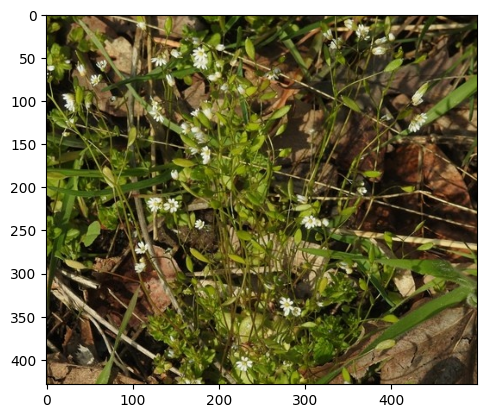

In [57]:
# рандомное фото из датасета other:

rnd_img_other = df_other.iloc[random.randint(0, df_other.shape[0]-1)]
im_other = rnd_img_other['file_paths'] 
im_other = Image.open(im_other)
plt.imshow(im_other)

Создадим защиту, на случай попадания фотографии, вообще не соответствующей растениям. Для этого будем использовать часть датасета ImageNet50:

In [15]:
paths = []
labels_list = []
for pic in os.listdir('data/imagenet_tiny'):
#    if pic not in plant_list and pic not in os.listdir('data/val'): 
    pic_path = os.path.join('data/imagenet_tiny', pic)
    paths.append(pic_path)
    labels_list.append('not_plant')
        
df_not_plant = pd.DataFrame()        
df_not_plant['file_paths'] = paths
df_not_plant['tree_types'] = labels_list
df_not_plant.shape, df_not_plant.head(5)


((10000, 2),
                          file_paths tree_types
 0  data/imagenet_tiny/val_3664.JPEG  not_plant
 1  data/imagenet_tiny/val_5900.JPEG  not_plant
 2  data/imagenet_tiny/val_5898.JPEG  not_plant
 3  data/imagenet_tiny/val_1097.JPEG  not_plant
 4  data/imagenet_tiny/val_7780.JPEG  not_plant)

In [16]:
pic_path

'data/imagenet_tiny/val_9630.JPEG'

Проверим, что находится в датафрейме `df_not_plant`:

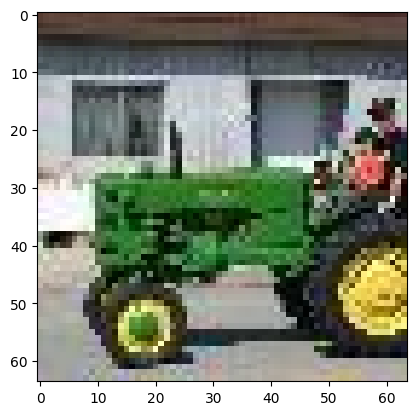

In [17]:
rnd = df_not_plant.iloc[random.randint(0, df_not_plant.shape[0]-1)]
im = rnd['file_paths']
im = Image.open(im)
plt.imshow(im)

# Target label encoding

Преобразуем метки классов (названия растений в столбце 'tree_types') в числовые значения:

Объединение датасетов:

In [18]:
df_full = pd.concat([df, df_other, df_not_plant])

df_full.sample(20)

,tree_types,file_paths
24128,Other,data/val/06494_Plantae_Tracheophyta_Magnoliops...
13332,Other,data/val/06611_Plantae_Tracheophyta_Magnoliops...
10147,Ulmus_minor,data/kb/Ulmus_minor/750c9e33-9fdb-43d9-a8a7-e8...
737,Other,data/val/07764_Plantae_Tracheophyta_Magnoliops...
1503,not_plant,data/imagenet_tiny/val_9459.JPEG
23486,Other,data/val/06319_Plantae_Tracheophyta_Liliopsida...
565,Salix_babylonica,data/kb/Salix_babylonica/7b40ef96-2ce3-451f-aa...
5848,Populus_tremula,data/kb/Populus_tremula/275d8e10-7585-4a83-b34...
8428,Pyrus_communis,data/kb/Pyrus_communis/50619ec1-46d5-4cf5-849c...
3349,not_plant,data/imagenet_tiny/val_8517.JPEG


In [19]:
# Сортировка в лексикографическом порядке:
df_full = df_full.sort_values('tree_types')

In [21]:
# Импорт LabelEncoder():
label_encoder = LabelEncoder()

In [58]:
# Добавление столбца 'labels' с метками клаcса в df_full:

df_full['labels'] = label_encoder.fit_transform(df_full['tree_types'])
df_full.sample(3)

,tree_types,file_paths,labels
19437,Other,data/val/09786_Plantae_Tracheophyta_Pinopsida_...,21
3703,Other,data/val/09372_Plantae_Tracheophyta_Magnoliops...,21
6390,not_plant,data/imagenet_tiny/val_90.JPEG,42


Создание словаря с метками классов для дальнейшнго использования с API:

In [23]:
# Словарь, в котором каждому уникальному значению из столбца 'tree_types' в df_full сопоставляется соответствующий числовой индекс.
label_dict = {i: class_name for i, class_name in enumerate(df_full['tree_types'].unique())}

In [24]:
# Открываем файл в режиме записи
with open ('data/label_dict.json', 'w') as f:
    # Сериализуем объект и записываем его в файл
    json.dump(label_dict, f)

In [25]:
# Контекстное управление with используется для автоматического закрытия файла после чтения
# десериализация объекта label_dict.json
with open('data/label_dict.json', 'r') as f:
    label_dict = json.load(f)
label_dict

{'0': 'Abies_alba',
 '1': 'Acer_campestre',
 '2': 'Acer_ginnala',
 '3': 'Acer_platanoides',
 '4': 'Acer_pseudoplatanus',
 '5': 'Acer_saccharinum',
 '6': 'Aesculus_hippocastanum',
 '7': 'Alnus_glutinosa',
 '8': 'Alnus_incana',
 '9': 'Betula_pendula',
 '10': 'Betula_pubescens',
 '11': 'Caragana_arborescens',
 '12': 'Carpinus_betulus',
 '13': 'Fraxinus_excelsior',
 '14': 'Fraxinus_pennsylvanica',
 '15': 'Juglans_mandshurica',
 '16': 'Juglans_regia',
 '17': 'Larix_sibirica',
 '18': 'Malus_domestica',
 '19': 'Malus_prunifolia',
 '20': 'Malus_toringo',
 '21': 'Other',
 '22': 'Picea_abies',
 '23': 'Pinus_sylvestris',
 '24': 'Populus_alba',
 '25': 'Populus_berolinensis',
 '26': 'Populus_nigra',
 '27': 'Populus_tremula',
 '28': 'Prunus_avium',
 '29': 'Prunus_cerasifera',
 '30': 'Prunus_domestica',
 '31': 'Pseudotsuga_menziesii',
 '32': 'Pyrus_communis',
 '33': 'Quercus_robur',
 '34': 'Quercus_rubra',
 '35': 'Salix_alba',
 '36': 'Salix_babylonica',
 '37': 'Tilia_cordata',
 '38': 'Tilia_platyphyl

Сократим объем данных для дальнейшей работы. Случайным образом выбирем 20% данных из каждой группы, сохранив при этом структуру данных.

In [26]:
df_full = df_full.groupby('tree_types', group_keys=False).apply(lambda x: x.sample(frac=0.2))

In [27]:
df_full.sample(10)

,tree_types,file_paths,labels
39365,Other,data/val/06498_Plantae_Tracheophyta_Magnoliops...,21
1838,Aesculus_hippocastanum,data/kb/Aesculus_hippocastanum/755b0bad-f1ef-4...,6
899,not_plant,data/imagenet_tiny/val_8274.JPEG,42
5551,Other,data/val/05934_Plantae_Tracheophyta_Liliopsida...,21
20770,Other,data/val/09891_Plantae_Tracheophyta_Polypodiop...,21
348,Other,data/val/08118_Plantae_Tracheophyta_Magnoliops...,21
34075,Other,data/val/08558_Plantae_Tracheophyta_Magnoliops...,21
5676,Populus_tremula,data/kb/Populus_tremula/76ed8c1f-d168-4785-855...,27
1279,Other,data/val/07375_Plantae_Tracheophyta_Magnoliops...,21
7461,not_plant,data/imagenet_tiny/val_2702.JPEG,42


In [28]:
# сохраним равномерное распределение классов в тестовой и трейновой выборках, используя нормализацию stratify=df_full['tree_types']

df_train, df_test = train_test_split(df_full, test_size = 0.1, shuffle=True, random_state=SEED, stratify=df_full['tree_types'])
df_train.shape, df_test.shape

((11333, 3), (1260, 3))

# Torch dataset preparation (подготовка торч-датасета)

In [29]:
# приведем все изображения к одному размеру 336х336 px:
img_size = (336, 336)

In [30]:
class TorchDataset(torch.utils.data.Dataset):
     #ручной класс, преобразующий изображение в тензор
   
    def __init__(self, dataframe, img_size):
        """В методе __init__ инициализируются атрибуты класса: dataframe, resize и to_tensor.
          dataframe - датафрейм, передаваемый в класс.
          resize -изменение размера входящего изображения до заданного в img_size с использованием сглаживания (antialias=True).
          to_tensor - преобразование изображения в тензор.""" 
      
        self.dataframe = dataframe
        self.resize = tv.transforms.Resize((img_size[0], img_size[1]), antialias=True)
        self.to_tensor = tv.transforms.ToTensor()

    def __len__(self):
        """Возвращает длину датафрейма."""
        return len(self.dataframe)

    def __getitem__(self, idx):
        """Получение изображения и его метки по заданному индексу idx, а также преобразование изображения в тензор."""
       
        image_path = self.dataframe.iloc[idx]['file_paths']
        image = Image.open(image_path)
        image = image.convert("RGB")
        image = self.resize(image)
        image = self.to_tensor(image)
        image = image[:3, :, :]
        
        label = self.dataframe.iloc[idx]['labels']
        label = torch.tensor(label, dtype=torch.long) 
        return image, label

Создаем torch_датасеты для модели:

In [32]:
train_dataset = TorchDataset(df_train, img_size)
test_dataset = TorchDataset(df_test, img_size)

Проверим работу ручного класса:

In [33]:
test_dataset.__getitem__(36)

(tensor([[[0.6549, 0.6588, 0.6667,  ..., 0.6157, 0.6000, 0.6000],
          [0.6549, 0.6588, 0.6667,  ..., 0.6196, 0.6078, 0.6118],
          [0.6510, 0.6588, 0.6667,  ..., 0.6235, 0.6078, 0.6078],
          ...,
          [0.4667, 0.4588, 0.4902,  ..., 0.1725, 0.1843, 0.2118],
          [0.3961, 0.3804, 0.4039,  ..., 0.1569, 0.1765, 0.1882],
          [0.4118, 0.3843, 0.3765,  ..., 0.1412, 0.2118, 0.2039]],
 
         [[0.8275, 0.8353, 0.8431,  ..., 0.6980, 0.6902, 0.6902],
          [0.8275, 0.8353, 0.8392,  ..., 0.7020, 0.6980, 0.7020],
          [0.8235, 0.8314, 0.8353,  ..., 0.7059, 0.6980, 0.6980],
          ...,
          [0.4784, 0.4706, 0.5020,  ..., 0.1529, 0.1608, 0.1882],
          [0.4039, 0.3922, 0.4157,  ..., 0.1373, 0.1529, 0.1647],
          [0.4196, 0.3922, 0.3882,  ..., 0.1255, 0.1922, 0.1882]],
 
         [[0.9647, 0.9647, 0.9725,  ..., 0.8235, 0.8157, 0.8157],
          [0.9647, 0.9647, 0.9725,  ..., 0.8275, 0.8235, 0.8275],
          [0.9608, 0.9647, 0.9686,  ...,

In [34]:
len(train_dataset)

11333

# Torch data loaders for train and test

Создаем загрузчик данных Torch data loader:

In [35]:
batch_size = 128
# тренировочный набор данных:
train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# тестовый набор данных:
test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

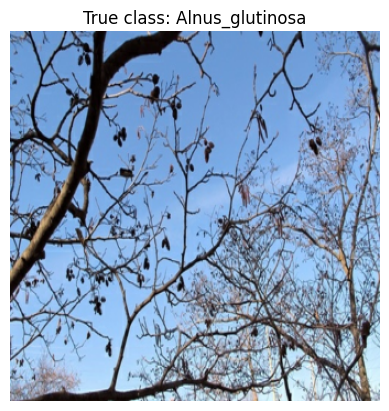

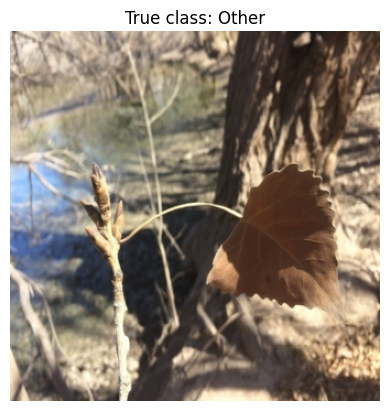

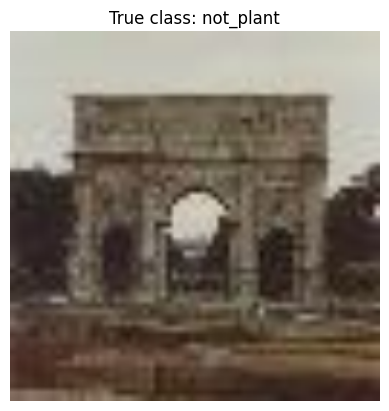

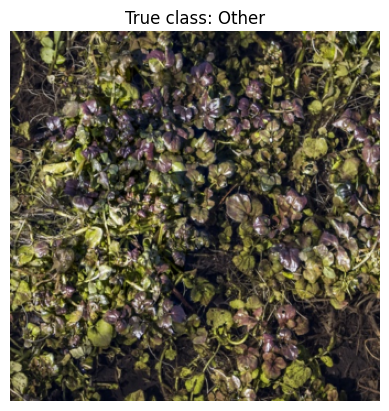

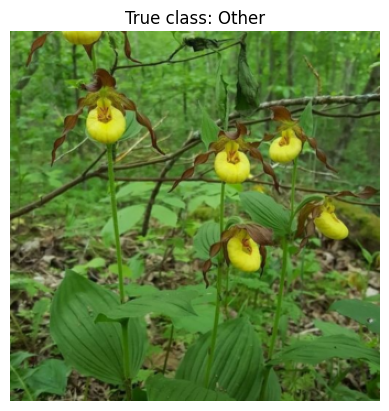

In [36]:
# Выведем первые 5 изображений из тренировочного набора данных, их метки и соответствующие классы
# в виде графиков с использованием библиотеки Matplotlib.

counter = 0
for batch_images, batch_labels in train:
    for image, label in zip(batch_images, batch_labels):
        image_np = np.array(image)
        image_np = np.transpose(image_np, (1, 2, 0))
        plt.imshow(image_np)
        plt.title(f"True class: {label_dict[str(label.item())]}")
        plt.axis('off')
        plt.show()
        counter += 1
        if counter == 5:
            break
    if counter == 5:
        break

In [37]:
# Кол-во нейронов на выходе для модели(=кол-ву уникальных меток классов):

class_count = len(df_full['tree_types'].unique())
class_count

43

# Vision Transformer

Представление работы архитектуры модели ViT:

![TP](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/model_doc/vit_architecture.jpg)

In [59]:
# создание собственной модели на основании предобученной:

vit = timm.create_model("hf_hub:timm/vit_large_patch14_clip_336.laion2b_ft_augreg_inat21", pretrained=True)

In [60]:
# используем веса предобученной модели без изменений:

for param in vit.parameters():
    param.requires_grad = False

In [61]:
# Кол-во выходных признаков последнего слоя модели:

vit_out_features = list(vit.modules())[-1].out_features
vit_out_features

10000

# Classification model

In [63]:
hidden = 16
model = torch.nn.Sequential(
    vit,
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.2, inplace=False),
    torch.nn.Linear(vit_out_features, hidden*class_count), # первый полносвязный слой, выполняет линейное преобраз-ие входных данных
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.2, inplace=False),
    torch.nn.Linear(hidden*class_count, class_count) # второй полносвязный слой
)

In [42]:
model = model.to(device)

In [43]:
model

Sequential(
  (0): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=1024, out_features=4

In [44]:
num_params = sum(torch.numel(param) for param in model.parameters())
print(f"Number of parameters: {num_params}")

Number of parameters: 320667771


In [45]:
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_trainable_params}")

Number of trainable parameters: 6910315


In [46]:
epochs =  4
lr = 0.0001
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Train model

In [47]:
def train_model(model, optimizer, n_epochs=10):
  for ep in range(n_epochs):
      print(f'Epoch {ep} started')
      train_iters, train_passed  = 0, 0
      train_loss, train_acc = 0., 0.

      print('Training model')
      model.train()
      for X, y in tqdm(train):
          X, y = X.to(device), y.to(device)
          optimizer.zero_grad() # сброс градиентов
          y_pred = model(X)
          l = loss(y_pred, y)
          l.backward() # вычисление градиентов
          optimizer.step() # шаг градиентного спуска
          train_loss += l.item()
          train_acc += (y_pred.argmax(dim=1) == y).sum().item()
          train_iters += 1
          train_passed += len(X)

      print('Evaluating model')
      model.eval()
      test_iters, test_passed  = 0, 0
      test_loss, test_acc = 0., 0.
      for X, y in tqdm(test):
          X, y = X.to(device), y.to(device)
          y_pred = model(X)
          l = loss(y_pred, y)
          test_loss += l.item()
          test_acc += (y_pred.argmax(dim=1) == y).sum().item()
          test_iters += 1
          test_passed += len(X)
          
      print("ep: {}, train_loss: {}, train_acc: {}, test_loss: {}, test_acc: {}".format(
          ep, train_loss / train_iters, train_acc / train_passed,
          test_loss / test_iters, test_acc / test_passed)
      )
      torch.cuda.empty_cache()

In [48]:
%%time
train_model(model, optimizer, epochs)

Epoch 0 started
Training model


  0%|          | 0/89 [00:00<?, ?it/s]

Evaluating model


  0%|          | 0/10 [00:00<?, ?it/s]

ep: 0, train_loss: 0.9339709884664985, train_acc: 0.846201358863496, test_loss: 0.388048543035984, test_acc: 0.9380952380952381
Epoch 1 started
Training model


  0%|          | 0/89 [00:00<?, ?it/s]

Evaluating model


  0%|          | 0/10 [00:00<?, ?it/s]

ep: 1, train_loss: 0.23558810160736018, train_acc: 0.959410570899144, test_loss: 0.1998488187789917, test_acc: 0.9626984126984127
Epoch 2 started
Training model


  0%|          | 0/89 [00:00<?, ?it/s]

Evaluating model


  0%|          | 0/10 [00:00<?, ?it/s]

ep: 2, train_loss: 0.11918080430687143, train_acc: 0.9781170034412777, test_loss: 0.16187388375401496, test_acc: 0.9722222222222222
Epoch 3 started
Training model


  0%|          | 0/89 [00:00<?, ?it/s]

Evaluating model


  0%|          | 0/10 [00:00<?, ?it/s]

ep: 3, train_loss: 0.07700956353310788, train_acc: 0.985352510367952, test_loss: 0.14503310546278952, test_acc: 0.9746031746031746
CPU times: user 36min 47s, sys: 30.3 s, total: 37min 18s
Wall time: 20min 42s


# Check on test images

True label:
not_plant
------
Predicted label:
not_plant
Probability: 100.0%
------
not_plant 100.0%
Tilia_platyphyllos 0.0%
Malus_domestica 0.0%


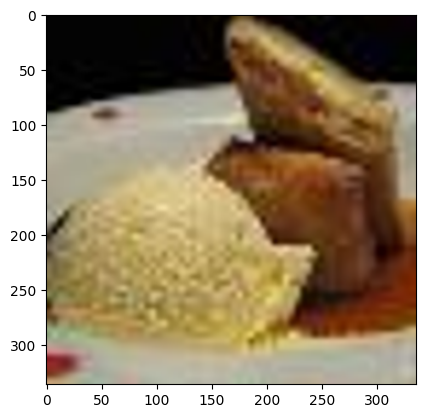

In [49]:
rnd = df_test.iloc[random.randint(0, df_test.shape[0]-1)]
im = rnd['file_paths']
label = rnd['tree_types']


image = Image.open(im)
image = image.resize((img_size[0], img_size[1]))
plt.imshow(image)

# transform to tensor
image = np.array(image)
image = image[:, :, :3]
image = torch.tensor(image).float() 
image = image.unsqueeze(0)
image = image.permute(0, 3, 1, 2)
image = image / 255.0

# infer model
with torch.no_grad():
    output = model(image.to(device))
    probabilities = torch.nn.functional.softmax(output, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1)
    top_probs, top_classes = torch.topk(probabilities, k=3, dim=1)

print(f'True label:\n{label}')
print('------')
print(f'Predicted label:\n{label_dict[str(predicted_class.item())]}')
print(f'Probability: {round(probabilities[0][predicted_class].item()*100, 2)}%')
print('------')
possible = [label_dict[str(pred.item())] for pred in top_classes[0]]
probs = [prob.item() for prob in top_probs[0]]
for pos, prob in zip(possible, probs):
    print(f'{pos} {round(prob*100, 2)}%')

# Top-k Accuracy and Classification report

In [50]:
%%time

total_samples = 0
correct_topk = 0

true_labels = []
predicted_labels = []

top_k = 2

with torch.no_grad():
    for images, labels in test:
        
        true_labels.extend(labels)
    
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = outputs.topk(top_k, dim=1) 

        # top_k accuracy
        total_samples += labels.size(0)
        correct_topk += sum([labels[i] in predicted[i] for i in range(labels.size(0))])

        # predictions for report
        predicted_labels.extend(predicted[:, 0].cpu().numpy())

topk_accuracy = 100.0 * correct_topk / total_samples
print(f"Top-{top_k} Accuracy: {topk_accuracy:.2f}%")

Top-2 Accuracy: 98.81%
CPU times: user 52.2 s, sys: 777 ms, total: 53 s
Wall time: 29.4 s


In [51]:
classification_rep = classification_report(true_labels, predicted_labels, output_dict=True)
classification_rep = pd.DataFrame(classification_rep).T
classification_rep

,precision,recall,f1-score,support
0,0.800000,1.000000,0.888889,4.000000
1,1.000000,1.000000,1.000000,6.000000
2,0.750000,1.000000,0.857143,6.000000
3,1.000000,1.000000,1.000000,6.000000
4,1.000000,1.000000,1.000000,6.000000
5,1.000000,1.000000,1.000000,6.000000
6,0.857143,1.000000,0.923077,6.000000
7,1.000000,1.000000,1.000000,6.000000
8,0.857143,1.000000,0.923077,6.000000
9,1.000000,1.000000,1.000000,6.000000


# Best recognized trees

In [52]:
top_f1 = list(classification_rep.sort_values('f1-score', ascending=False).head(10).index)

In [53]:
[' '.join(label_dict[label].split('_')) for label in top_f1][-10:]

['Acer campestre',
 'Acer platanoides',
 'Acer saccharinum',
 'Acer pseudoplatanus',
 'Betula pendula',
 'Alnus glutinosa',
 'Caragana arborescens',
 'Pinus sylvestris',
 'Prunus cerasifera',
 'Populus tremula']

# Save model

In [55]:
torch.save(model, 'models/plants_vit_33.pth')